In [210]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import misc
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers.convolutional import Conv2D
from keras.layers import *
from keras import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,TensorBoard, Callback
import matplotlib.pyplot as plt
%matplotlib nbagg
from keras.utils import np_utils
from keras import backend as K
import cv2
from common import util
from sklearn.model_selection import train_test_split
import random
import glob
import tensorflow as tf
K.set_image_dim_ordering('th')

In [93]:
def hot_vectorize(x,value = 65287.0):
    zero_mask = x==value
    non_zero_mask = x!=value
    x[zero_mask] = 1
    x[non_zero_mask] = 0
    return x.astype(float)

def stack_frames(frames,img_height,img_width,channels):
    stack  = np.zeros((1,img_height,img_width,channels))
    index = 0
    for i in frames:
        num_chan = 1 if len(np.shape(i)) ==2 else np.shape(i)[2]
        stack[0,:,:,index:index+num_chan] = np.reshape(i,(img_height,img_width,num_chan))
        index += num_chan
    return stack

def grab_frame(files,i,path,func=None):
    img = misc.imread(path+files[i])
    if func:
        return func(img)
    return img

def grab_frame1(path,func=None):
    img = misc.imread(path)
    if func:
        return func(img)
    return img

def normalize(x):
    return x.astype(float)/255.

def normalize_depth(x):
    return x.astype(float)/3000.

def convert_rgb_normal(img):
    return (img/255.*2)-1

def bounding_box(img,size = 100):
    h,w = np.shape(img)
    non_zeros = np.nonzero(img)
    x_min = np.min(non_zeros[0])
    x_max = np.max(non_zeros[0])
    y_min = np.min(non_zeros[1])
    y_max = np.max(non_zeros[1])
    out = (x_min,x_min+size,y_min,y_min+size) if size else (x_min,x_max,y_min,y_max)#minuce or plus coordinates
    if x_min< 0 or x_min+size > h or y_min<0 or y_min+size>w:
        return None
    return out

In [177]:
misc.imread('/media/drc/d92620ab-ae06-485e-8546-43a7a2d73059/living_room_0001a/r-1294634086.923360-3812003162.ppm')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


array(<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=640x480 at 0x7FA3BFD26E90>,
      dtype=object)

In [59]:
a = gen_samples("/media/drc/d92620ab-ae06-485e-8546-43a7a2d73059")

In [205]:
gen = generate_data_custom_nyu(a)

In [58]:
def gen_samples(directory,shuffle = True):
    samples = []
    dirs = os.listdir(directory)
    for i in dirs:
        path = os.path.join(directory, i)+"/"
        if os.access(path, os.R_OK):
            rgb = sorted(glob.glob(path+"r-*"))
            depth = sorted(glob.glob(path+"d-*"))
            samples.extend(zip(rgb,depth))
    if shuffle:
        random.shuffle(samples)
    return samples                

In [201]:
def generate_data_custom_nyu(samples,img_height=480,img_width=640,batch_size=8):
    i = 0
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,3))
        stack2 = np.zeros((batch_size,img_height,img_width,1))
        j=0
        while j<batch_size:
            try:
                rgb = samples[i][0]
                depth = samples[i][1]
                rgb_img = grab_frame1(rgb,normalize)
                depth_img = grab_frame1(depth,hot_vectorize)
                stack1[j] = np.reshape(rgb_img,(img_height,img_width,3))
                stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
                j+=1
                i= (i+1)%len(samples)
            except(IOError,TypeError,ValueError):
                i= (i+1)%len(samples)
                continue
        yield (stack1,stack2)

In [132]:
def generate_data_custom1(depth_as_mask=True,img_height=480,img_width=640,batch_size=4,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"
    depth_path = path+"depth/"

    rgb = np.sort(os.listdir(rgb_path))
    depth = np.sort(os.listdir(depth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            depth = np.sort(filter(lambda x: filter_files in x, depth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,3))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(rgb)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
          
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            stack = stack_frames([rgb_img],img_height,img_width,3)
            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [13]:
def generate_data_custom3(depth_as_mask=True,img_height=480,img_width=640,batch_size=8,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"+"rgb/"
    depth_path = path+"depth/"+ "depth/"
    gtdepth_path = path+"gtdepth/" + "gtdepth/"
    normal_path = path+"normal/" + "normal/"

    rgb = np.sort(os.listdir(rgb_path))
    normal = np.sort(os.listdir(normal_path))
    depth = np.sort(os.listdir(depth_path))
    gtdepth = np.sort(os.listdir(gtdepth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            normal = np.sort(filter(lambda x: filter_files in x, normal))
            depth = np.sort(filter(lambda x: filter_files in x, depth))
            gtdepth = np.sort(filter(lambda x: filter_files in x, gtdepth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,7))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(depth)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
            normal_img = grab_frame(normal,i,normal_path,normalize)
            gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            gtdepth_img[gtdepth_img==0]=1.

            stack = stack_frames([gtdepth_img,normal_img,rgb_img],img_height,img_width,7)
            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [14]:
def generate_data_custom(depth_as_mask=True,img_height=480,img_width=640,batch_size=8,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"+"rgb/"
    depth_path = path+"depth/"+ "depth/"
    gtdepth_path = path+"gtdepth/" + "gtdepth/"
    normal_path = path+"normal/" + "normal/"

    rgb = np.sort(os.listdir(rgb_path))
    normal = np.sort(os.listdir(normal_path))
    depth = np.sort(os.listdir(depth_path))
    gtdepth = np.sort(os.listdir(gtdepth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            normal = np.sort(filter(lambda x: filter_files in x, normal))
            depth = np.sort(filter(lambda x: filter_files in x, depth))
            gtdepth = np.sort(filter(lambda x: filter_files in x, gtdepth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,4))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(depth)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
            normal_img = grab_frame(normal,i,normal_path,normalize)
            gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            a = bounding_box(gtdepth_img,img_height)
            while not a:
                i= (i+1)%len(depth)
                rgb_img = grab_frame(rgb,i,rgb_path,func)
                normal_img = grab_frame(normal,i,normal_path,normalize)
                gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
                depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
                a = bounding_box(gtdepth_img,img_height)

            x1,x2,y1,y2 = a
            depth_img = depth_img[x1:x2,y1:y2] 
            gtdepth_img = gtdepth_img[x1:x2,y1:y2]
            normal_img = normal_img[x1:x2,y1:y2]
            gtdepth_img[gtdepth_img==0]=1.

            stack = stack_frames([gtdepth_img,normal_img,rgb_img],img_height,img_width,4)
            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [15]:
gen  = generate_data_custom3(func=normalize)

In [108]:
np.shape(now[0])

(8, 480, 640, 3)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


<IPython.core.display.Javascript object>


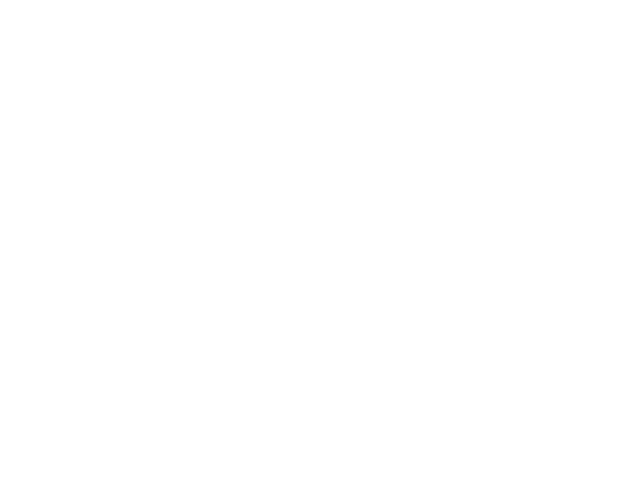

<IPython.core.display.Javascript object>


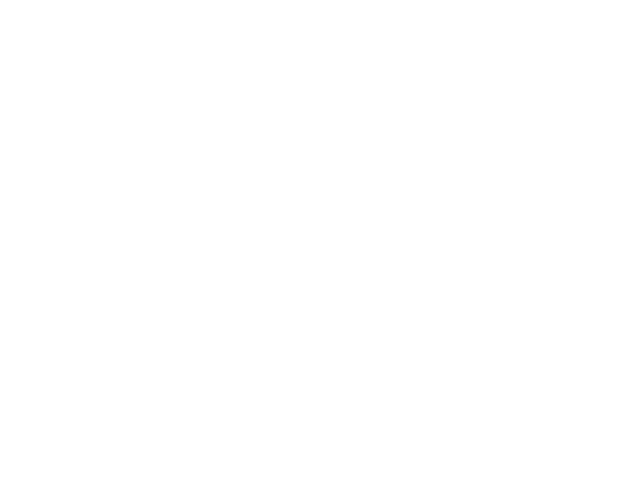

In [206]:
%matplotlib nbagg
h = 480
w = 640
now = gen.next()
plt.figure()
plt.imshow(np.reshape(now[1][1],(h,w)))
plt.figure()
plt.imshow(np.reshape(now[0][1,:,:,:],(h,w,3)))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


<IPython.core.display.Javascript object>


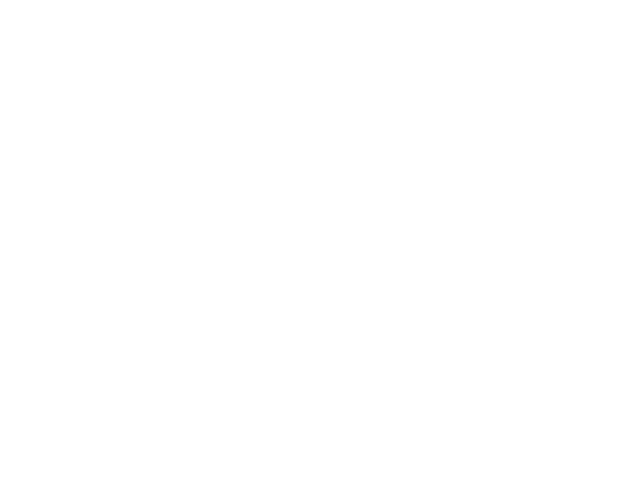

<IPython.core.display.Javascript object>


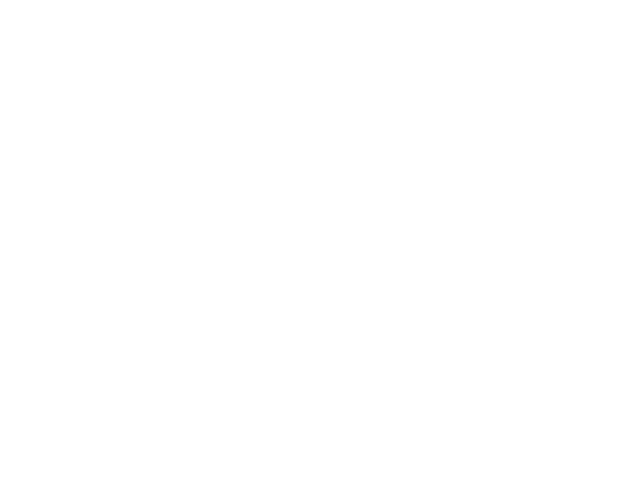

<IPython.core.display.Javascript object>


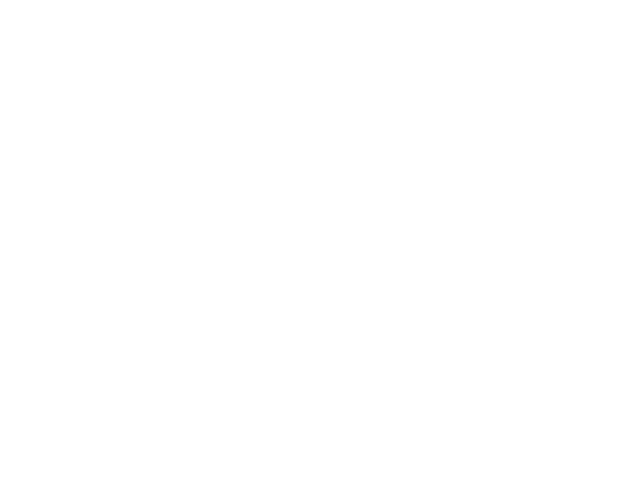

<IPython.core.display.Javascript object>


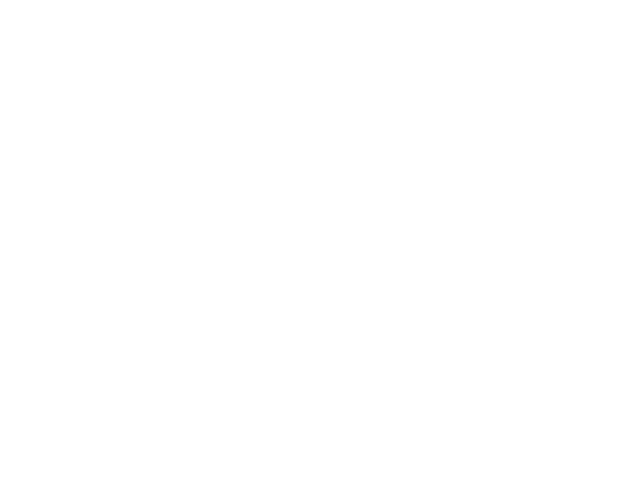

In [16]:
%matplotlib nbagg
now = gen.next()
plt.figure()
plt.imshow(np.reshape(now[1][0],(480,640)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,0],(480,640)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,1:4],(480,640,3)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,4:],(480,640,3)))

In [102]:
img_height = 480 #check with old params
img_width = 640
inputs = Input((img_height, img_width,3))

In [137]:
#crop = Cropping2D(cropping=((0, 0), (0, 0)), data_format=None)
conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(inputs)
conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv1)

conv2 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool1)
conv2 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv2)

conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool2)
conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv3)


conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool3)
conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv5)
drop5 = Dropout(0.5)(conv5)

up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv5))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge7)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv7)

up8 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge8)
conv8 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv8)

up9 = Conv2D(4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge9)
conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid',data_format='channels_last')(conv9)

model = Model(input = inputs, output = conv10)
print model.summary()
model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 200, 200, 4)  0                                            
__________________________________________________________________________________________________
conv2d_210 (Conv2D)             (None, 200, 200, 4)  148         input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_211 (Conv2D)             (None, 200, 200, 4)  148         conv2d_210[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_50 (MaxPooling2D) (None, 100, 100, 4)  0           conv2d_211[0][0]                 
__________________________________________________________________________________________________
conv2d_212

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [110]:
#crop = Cropping2D(cropping=((0, 0), (0, 0)), data_format=None) #check with updated param in the middle weird???
conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(inputs)
conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv1)

conv2 = Conv2D(14, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool1)
conv2 = Conv2D(14, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv2)

conv3 = Conv2D(28, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool2)
conv3 = Conv2D(28, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv3)

conv4 = Conv2D(56, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool3)
conv4 = Conv2D(56, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(drop4)

conv5 = Conv2D(136, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool4)
conv5 = Conv2D(136, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(112, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(drop5))
merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
conv6 = Conv2D(112, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge6)
conv6 = Conv2D(112, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv6)

up7 = Conv2D(56, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv6))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(56, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge7)
conv7 = Conv2D(56, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv7)

up8 = Conv2D(28, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(28, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge8)
conv8 = Conv2D(28, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv8)

up9 = Conv2D(14, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(14, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge9)
conv9 = Conv2D(14, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid',data_format='channels_last')(conv9)

model = Model(input = inputs, output = conv10)
print model.summary()
model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 640, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 480, 640, 4)  112         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 480, 640, 4)  148         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 240, 320, 4)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:34: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: UserWarning: The `m

In [25]:
#model.load_weights('unet_7channelfixed_batchsize4.hdf5')

In [224]:
class Image_Saver(Callback):
    def on_train_begin(self,logs={}):
        pass

    def on_batch_end(self, batch, logs={}):
        if type(batch)!=int:
            x=self.model.predict_on_batch(batch)
            writer = tf.summary.FileWriter('/media/drc/DATA/tensor_log')
            writer.add_summary(tf.summary.image('input', x[0]))
save = Image_Saver()

In [ ]:
model_checkpoint = ModelCheckpoint('net_rgbnyu_batchsize8.hdf5', monitor='loss',verbose=1, save_best_only=True)
check2 = TensorBoard(log_dir='/media/drc/DATA/tensor_log', histogram_freq=0, batch_size=8, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
print('Fitting model...')
model.fit_generator(gen, nb_epoch=10000,steps_per_epoch=100, verbose=1, shuffle=True, callbacks=[model_checkpoint,check2,save])

Fitting model...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., shuffle=True, verbose=1, steps_per_epoch=100, epochs=10000, callbacks=[<keras.ca...)`
  after removing the cwd from sys.path.


Epoch 1/10000


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


 99/100 [============================>.] - ETA: 0s - loss: 0.3119 - acc: 0.8824
Epoch 00001: loss improved from inf to 0.31335, saving model to net_rgbnyu_batchsize8.hdf5
100/100 [==============================] - 84s 838ms/step - loss: 0.3134 - acc: 0.8815
Epoch 2/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3039 - acc: 0.8880
Epoch 00002: loss improved from 0.31335 to 0.30348, saving model to net_rgbnyu_batchsize8.hdf5
100/100 [==============================] - 82s 824ms/step - loss: 0.3035 - acc: 0.8883
Epoch 3/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3339 - acc: 0.8722
Epoch 00003: loss did not improve
100/100 [==============================] - 82s 825ms/step - loss: 0.3339 - acc: 0.8721
Epoch 4/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3277 - acc: 0.8766
Epoch 00004: loss did not improve
100/100 [==============================] - 83s 834ms/step - loss: 0.3279 - acc: 0.8763
Epoch 5/10000
 99/100 [=============

 99/100 [============================>.] - ETA: 0s - loss: 0.3139 - acc: 0.8810
Epoch 00038: loss did not improve
100/100 [==============================] - 83s 831ms/step - loss: 0.3151 - acc: 0.8802
Epoch 39/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3065 - acc: 0.8871
Epoch 00039: loss did not improve
100/100 [==============================] - 83s 831ms/step - loss: 0.3056 - acc: 0.8874
Epoch 40/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3236 - acc: 0.8766
Epoch 00040: loss did not improve
100/100 [==============================] - 83s 832ms/step - loss: 0.3228 - acc: 0.8770
Epoch 41/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3236 - acc: 0.8769
Epoch 00041: loss did not improve
100/100 [==============================] - 83s 833ms/step - loss: 0.3232 - acc: 0.8772
Epoch 42/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3046 - acc: 0.8858
Epoch 00042: loss did not improve
100/100 [=============

Epoch 76/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3071 - acc: 0.8851
Epoch 00076: loss did not improve
100/100 [==============================] - 83s 833ms/step - loss: 0.3083 - acc: 0.8849
Epoch 77/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3000 - acc: 0.8865
Epoch 00077: loss did not improve
100/100 [==============================] - 83s 834ms/step - loss: 0.3000 - acc: 0.8864
Epoch 78/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3081 - acc: 0.8823
Epoch 00078: loss did not improve
100/100 [==============================] - 83s 833ms/step - loss: 0.3083 - acc: 0.8824
Epoch 79/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3182 - acc: 0.8784
Epoch 00079: loss did not improve
100/100 [==============================] - 83s 832ms/step - loss: 0.3187 - acc: 0.8781
Epoch 80/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3168 - acc: 0.8775
Epoch 00080: loss did not improve
100/100

Epoch 114/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3036 - acc: 0.8859
Epoch 00114: loss did not improve
100/100 [==============================] - 84s 837ms/step - loss: 0.3032 - acc: 0.8861
Epoch 115/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3088 - acc: 0.8817
Epoch 00115: loss did not improve
100/100 [==============================] - 84s 837ms/step - loss: 0.3089 - acc: 0.8817
Epoch 116/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2980 - acc: 0.8883
Epoch 00116: loss did not improve
100/100 [==============================] - 84s 837ms/step - loss: 0.2979 - acc: 0.8882
Epoch 117/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3145 - acc: 0.8781
Epoch 00117: loss did not improve
100/100 [==============================] - 84s 836ms/step - loss: 0.3147 - acc: 0.8779
Epoch 118/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3090 - acc: 0.8811
Epoch 00118: loss did not improve
10

Epoch 152/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3051 - acc: 0.8856
Epoch 00152: loss did not improve
100/100 [==============================] - 84s 837ms/step - loss: 0.3046 - acc: 0.8858
Epoch 153/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3004 - acc: 0.8867
Epoch 00153: loss did not improve
100/100 [==============================] - 84s 837ms/step - loss: 0.3010 - acc: 0.8862
Epoch 154/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3055 - acc: 0.8816
Epoch 00154: loss did not improve
100/100 [==============================] - 84s 837ms/step - loss: 0.3055 - acc: 0.8818
Epoch 155/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3117 - acc: 0.8778
Epoch 00155: loss did not improve
100/100 [==============================] - 84s 836ms/step - loss: 0.3117 - acc: 0.8778
Epoch 156/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3055 - acc: 0.8828
Epoch 00156: loss did not improve
10

Epoch 190/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3016 - acc: 0.8847
Epoch 00190: loss did not improve
100/100 [==============================] - 84s 838ms/step - loss: 0.3016 - acc: 0.8848
Epoch 191/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2923 - acc: 0.8864
Epoch 00191: loss did not improve
100/100 [==============================] - 84s 838ms/step - loss: 0.2927 - acc: 0.8862
Epoch 192/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2955 - acc: 0.8856
Epoch 00192: loss did not improve
100/100 [==============================] - 84s 838ms/step - loss: 0.2959 - acc: 0.8852
Epoch 193/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2963 - acc: 0.8851
Epoch 00193: loss did not improve
100/100 [==============================] - 84s 837ms/step - loss: 0.2956 - acc: 0.8855
Epoch 194/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.3026 - acc: 0.8832
Epoch 00194: loss did not improve
10

Epoch 228/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2879 - acc: 0.8888
Epoch 00228: loss did not improve
100/100 [==============================] - 84s 838ms/step - loss: 0.2885 - acc: 0.8885
Epoch 229/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2776 - acc: 0.8935
Epoch 00229: loss improved from 0.28275 to 0.27684, saving model to net_rgbnyu_batchsize8.hdf5
100/100 [==============================] - 84s 840ms/step - loss: 0.2768 - acc: 0.8939
Epoch 230/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2957 - acc: 0.8867
Epoch 00230: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.2957 - acc: 0.8866
Epoch 231/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2967 - acc: 0.8859
Epoch 00231: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.2966 - acc: 0.8858
Epoch 232/10000
 99/100 [============================>.] - ETA: 0s - lo

Epoch 266/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2946 - acc: 0.8842
Epoch 00266: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.2936 - acc: 0.8847
Epoch 267/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2907 - acc: 0.8856
Epoch 00267: loss did not improve
100/100 [==============================] - 84s 838ms/step - loss: 0.2911 - acc: 0.8854
Epoch 268/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2938 - acc: 0.8873
Epoch 00268: loss did not improve
100/100 [==============================] - 84s 838ms/step - loss: 0.2946 - acc: 0.8867
Epoch 269/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2951 - acc: 0.8866
Epoch 00269: loss did not improve
100/100 [==============================] - 84s 838ms/step - loss: 0.2946 - acc: 0.8870
Epoch 270/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2936 - acc: 0.8858
Epoch 00270: loss did not improve
10

Epoch 304/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2922 - acc: 0.8859
Epoch 00304: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.2930 - acc: 0.8854
Epoch 305/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2832 - acc: 0.8914
Epoch 00305: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.2831 - acc: 0.8915
Epoch 306/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2837 - acc: 0.8907
Epoch 00306: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.2836 - acc: 0.8907
Epoch 307/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2883 - acc: 0.8885
Epoch 00307: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.2878 - acc: 0.8889
Epoch 308/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2877 - acc: 0.8868
Epoch 00308: loss did not improve
10

Epoch 342/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2731 - acc: 0.8961
Epoch 00342: loss improved from 0.27612 to 0.27198, saving model to net_rgbnyu_batchsize8.hdf5
100/100 [==============================] - 84s 842ms/step - loss: 0.2720 - acc: 0.8966
Epoch 343/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2836 - acc: 0.8908
Epoch 00343: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.2836 - acc: 0.8907
Epoch 344/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2787 - acc: 0.8922
Epoch 00344: loss did not improve
100/100 [==============================] - 84s 838ms/step - loss: 0.2793 - acc: 0.8919
Epoch 345/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2907 - acc: 0.8856
Epoch 00345: loss did not improve
100/100 [==============================] - 84s 838ms/step - loss: 0.2904 - acc: 0.8857
Epoch 346/10000
 99/100 [============================>.] - ETA: 0s - lo

 99/100 [============================>.] - ETA: 0s - loss: 0.2799 - acc: 0.8919
Epoch 00379: loss did not improve
100/100 [==============================] - 84s 838ms/step - loss: 0.2795 - acc: 0.8922
Epoch 380/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2764 - acc: 0.8923
Epoch 00380: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.2764 - acc: 0.8923
Epoch 381/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2782 - acc: 0.8916
Epoch 00381: loss did not improve
100/100 [==============================] - 84s 840ms/step - loss: 0.2785 - acc: 0.8915
Epoch 382/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2779 - acc: 0.8937
Epoch 00382: loss did not improve
100/100 [==============================] - 84s 840ms/step - loss: 0.2786 - acc: 0.8933
Epoch 383/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2812 - acc: 0.8907
Epoch 00383: loss did not improve
100/100 [=========

Epoch 417/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2889 - acc: 0.8864
Epoch 00417: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.2884 - acc: 0.8868
Epoch 418/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2823 - acc: 0.8889
Epoch 00418: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.2825 - acc: 0.8888
Epoch 419/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2756 - acc: 0.8932
Epoch 00419: loss did not improve
100/100 [==============================] - 84s 838ms/step - loss: 0.2760 - acc: 0.8929
Epoch 420/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2780 - acc: 0.8913
Epoch 00420: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.2769 - acc: 0.8919
Epoch 421/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2838 - acc: 0.8892
Epoch 00421: loss did not improve
10

Epoch 455/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2662 - acc: 0.8998
Epoch 00455: loss improved from 0.26576 to 0.26545, saving model to net_rgbnyu_batchsize8.hdf5
100/100 [==============================] - 84s 841ms/step - loss: 0.2654 - acc: 0.9002
Epoch 456/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2778 - acc: 0.8909
Epoch 00456: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.2785 - acc: 0.8904
Epoch 457/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2632 - acc: 0.8994
Epoch 00457: loss improved from 0.26545 to 0.26273, saving model to net_rgbnyu_batchsize8.hdf5
100/100 [==============================] - 84s 841ms/step - loss: 0.2627 - acc: 0.8997
Epoch 458/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2726 - acc: 0.8953
Epoch 00458: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.2739 - acc: 0.8946
Epoch 459/

 99/100 [============================>.] - ETA: 0s - loss: 0.2761 - acc: 0.8909
Epoch 00492: loss did not improve
100/100 [==============================] - 84s 840ms/step - loss: 0.2760 - acc: 0.8909
Epoch 493/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2713 - acc: 0.8968
Epoch 00493: loss did not improve
100/100 [==============================] - 84s 840ms/step - loss: 0.2708 - acc: 0.8971
Epoch 494/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2702 - acc: 0.8949
Epoch 00494: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.2704 - acc: 0.8948
Epoch 495/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2634 - acc: 0.8986
Epoch 00495: loss improved from 0.26273 to 0.26262, saving model to net_rgbnyu_batchsize8.hdf5
100/100 [==============================] - 84s 842ms/step - loss: 0.2626 - acc: 0.8990
Epoch 496/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2714 - acc

Epoch 529/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2564 - acc: 0.9017
Epoch 00529: loss improved from 0.26019 to 0.25593, saving model to net_rgbnyu_batchsize8.hdf5
100/100 [==============================] - 84s 842ms/step - loss: 0.2559 - acc: 0.9020
Epoch 530/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2694 - acc: 0.8961
Epoch 00530: loss did not improve
100/100 [==============================] - 84s 841ms/step - loss: 0.2687 - acc: 0.8964
Epoch 531/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2664 - acc: 0.8968
Epoch 00531: loss did not improve
100/100 [==============================] - 84s 841ms/step - loss: 0.2665 - acc: 0.8968
Epoch 532/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2767 - acc: 0.8898
Epoch 00532: loss did not improve
100/100 [==============================] - 84s 840ms/step - loss: 0.2770 - acc: 0.8897
Epoch 533/10000
 99/100 [============================>.] - ETA: 0s - lo

Epoch 567/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2675 - acc: 0.8965
Epoch 00567: loss did not improve
100/100 [==============================] - 84s 840ms/step - loss: 0.2675 - acc: 0.8964
Epoch 568/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2715 - acc: 0.8954
Epoch 00568: loss did not improve
100/100 [==============================] - 84s 839ms/step - loss: 0.2702 - acc: 0.8961
Epoch 569/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2823 - acc: 0.8890
Epoch 00569: loss did not improve
100/100 [==============================] - 84s 840ms/step - loss: 0.2820 - acc: 0.8891
Epoch 570/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2648 - acc: 0.8976
Epoch 00570: loss did not improve
100/100 [==============================] - 84s 841ms/step - loss: 0.2656 - acc: 0.8973
Epoch 571/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2645 - acc: 0.8970
Epoch 00571: loss did not improve
10

Epoch 605/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2576 - acc: 0.9008
Epoch 00605: loss did not improve
100/100 [==============================] - 84s 837ms/step - loss: 0.2574 - acc: 0.9009
Epoch 606/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2625 - acc: 0.8973
Epoch 00606: loss did not improve
100/100 [==============================] - 85s 852ms/step - loss: 0.2631 - acc: 0.8971
Epoch 607/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2660 - acc: 0.8973
Epoch 00607: loss did not improve
100/100 [==============================] - 84s 836ms/step - loss: 0.2655 - acc: 0.8975
Epoch 608/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2673 - acc: 0.8962
Epoch 00608: loss did not improve
100/100 [==============================] - 83s 832ms/step - loss: 0.2670 - acc: 0.8962
Epoch 609/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.2666 - acc: 0.8953
Epoch 00609: loss did not improve
10

In [ ]:
X_Test1 = np.copy(X_Test)
X_Test1[:,:,:,0]=0
X_Test1[:,:,:,1:4]=0
#X_Test1[:,:,:,4:]=0
imgs_mask_test = model.predict_on_batch(X_Test1)

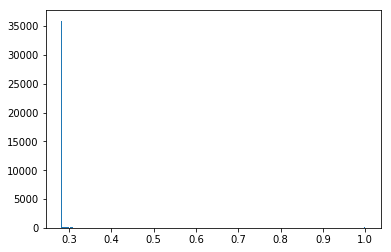

In [162]:
plt.figure()
plt.hist(img.ravel(), bins=256)
plt.show()

In [227]:
test = gen.next()
X_Test = test[0][0:1]

Y_Test = test[1][0:1]
imgs_mask_test = model.predict_on_batch(X_Test)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


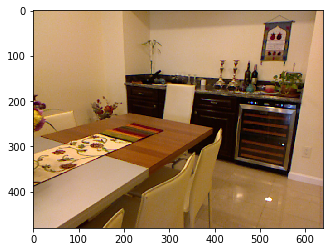

In [231]:
%matplotlib inline
img = np.reshape(X_Test[0][:,:,:],(img_height,img_width,3))
plt.imshow(img)

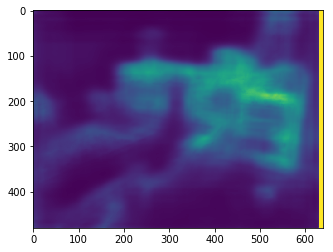

In [232]:
%matplotlib inline
img = np.reshape(imgs_mask_test[0],(img_height,img_width))
plt.imshow(img)

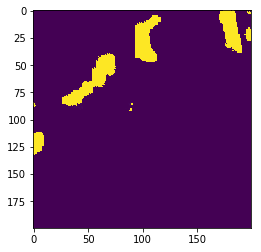

In [185]:
img1 = np.copy(img)
img1[img1>.3] =1
plt.imshow(img1)

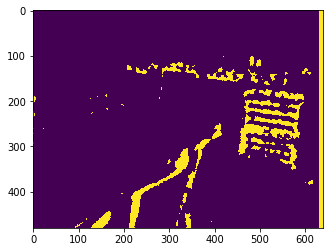

In [228]:
%matplotlib inline
img1 = np.reshape(Y_Test[0],(img_height,img_width))
plt.imshow(img1)

In [169]:
train = train_generator.next()
X = train[0]
Y = train[1]
inputs = Input((1,img_height, img_width))

In [171]:
conv1 = Conv2D(32, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(inputs)

conv2 = Conv2D(64, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv1)

conv3 = Conv2D(32, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv2)

conv4 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv3)
#drop4 = Dropout(0.5)(conv4)

conv5 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv4)

conv6 = Conv2D(1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv5)
#drop5 = Dropout(0.5)(conv5)


model1 = Model(input = inputs, output = conv6)
print model1.summary()
model1.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 480, 640)       0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 32, 480, 640)      832       
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 64, 480, 640)      51264     
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 32, 480, 640)      51232     
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 16, 480, 640)      4624      
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 4, 480, 640)       580       
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 1, 480, 640)       37        
Total para

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`
  from ipykernel import kernelapp as app


In [217]:
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
print('Fitting model...')
model1.fit_generator(train_generator, steps_per_epoch=100,nb_epoch=10, verbose=1, shuffle=True, callbacks=[model_checkpoint])

Fitting model...
Epoch 1/10
  1/100 [..............................] - ETA: 13s - loss: 0.3969 - acc: 0.8304

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<itertools..., shuffle=True, verbose=1, steps_per_epoch=100, epochs=10, callbacks=[<keras.ca...)`
  This is separate from the ipykernel package so we can avoid doing imports until


 99/100 [============================>.] - ETA: 0s - loss: 0.3890 - acc: 0.8321
Epoch 00001: loss improved from inf to 0.38894, saving model to unet.hdf5
100/100 [==============================] - 10s 100ms/step - loss: 0.3889 - acc: 0.8322
Epoch 2/10
 99/100 [============================>.] - ETA: 0s - loss: 0.3845 - acc: 0.8345
Epoch 00002: loss improved from 0.38894 to 0.38439, saving model to unet.hdf5
100/100 [==============================] - 10s 97ms/step - loss: 0.3844 - acc: 0.8345
Epoch 3/10
 99/100 [============================>.] - ETA: 0s - loss: 0.3850 - acc: 0.8282
Epoch 00003: loss did not improve
100/100 [==============================] - 10s 97ms/step - loss: 0.3851 - acc: 0.8281
Epoch 4/10
 99/100 [============================>.] - ETA: 0s - loss: 0.3777 - acc: 0.8301
Epoch 00004: loss improved from 0.38439 to 0.37768, saving model to unet.hdf5
100/100 [==============================] - 10s 98ms/step - loss: 0.3777 - acc: 0.8301
Epoch 5/10
 99/100 [==================

In [229]:
test = train_generator.next()
X_Test = test[0][0:50]
Y_Test = test[1][0:50]

In [232]:
np.shape(X_Test),np.shape(imgs_mask_test)

((1, 1, 480, 640), (1, 1, 480, 640))

In [236]:
imgs_mask_test = model1.predict_on_batch(X_Test)

In [284]:
%matplotlib inline

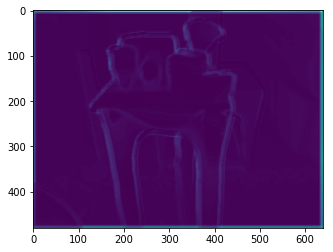

In [242]:
index = np.random.randint(10)
img = np.reshape(imgs_mask_test,(img_height,img_width))
plt.imshow(img)

In [34]:
count = 0

In [177]:
from PIL import Image
im = Image.open(img)
plt.imshow(im)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


<IPython.core.display.Javascript object>


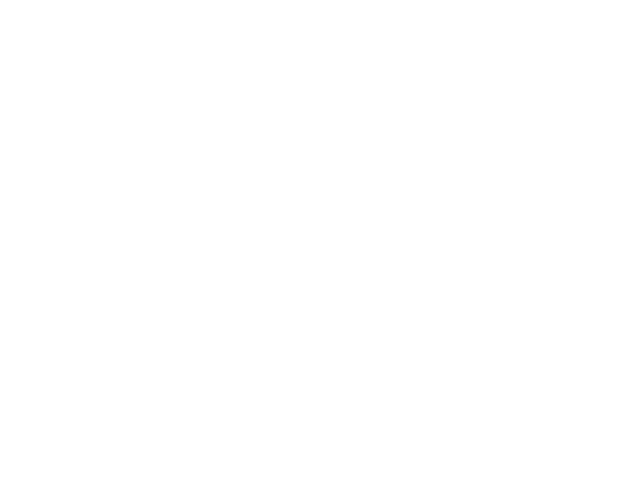

In [187]:
%matplotlib nbagg
path = "/media/drc/DATA/CNN/gtdepth/gtdepth/0000000007_2017-05-25-19_depth_ground_truth.png"
#path = "/media/drc/DATA/CNN/gtdepth/gtdepth/"
#img = path+ os.listdir(path)[count]
test =  misc.imresize(misc.imread(path),(480,640))
plt.imshow(test)
count+=1

In [282]:
%%timeit
perlin(x,y,seed=2)

100 loops, best of 3: 4.57 ms per loop


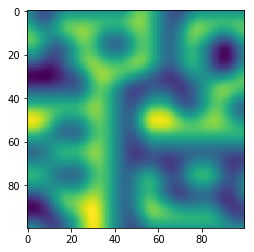

In [269]:
def perlin(x,y,seed=0):
    # permutation table
    np.random.seed(seed)
    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()
    # coordinates of the top-left
    xi = x.astype(int)
    yi = y.astype(int)
    # internal coordinates
    xf = x - xi
    yf = y - yi
    # fade factors
    u = fade(xf)
    v = fade(yf)
    # noise components
    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)
    # combine noises
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u) # FIX1: I was using n10 instead of n01
    return lerp(x1,x2,v) # FIX2: I also had to reverse x1 and x2 here

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y

lin = np.linspace(0,5,100,endpoint=False)
x,y = np.meshgrid(lin,lin) # FIX3: I thought I had to invert x and y here but it was a mistake
plt.figure()
plt.imshow(perlin(x,y,seed=2),origin='upper')

In [270]:
img

array([[0.7112028, 0.7112028, 0.7112028, ..., 0.7112028, 0.7112028,
        0.7112028],
       [0.7112028, 0.7112028, 0.7112028, ..., 0.7112028, 0.7112028,
        0.7112028],
       [0.7112028, 0.7112028, 0.7112028, ..., 0.7112028, 0.7112028,
        0.7112028],
       ...,
       [0.7112028, 0.7112028, 0.7112028, ..., 0.7112028, 0.7112028,
        0.7112028],
       [0.7112028, 0.7112028, 0.7112028, ..., 0.7112028, 0.7112028,
        0.7112028],
       [0.7112028, 0.7112028, 0.7112028, ..., 0.7112028, 0.7112028,
        0.7112028]], dtype=float32)

In [281]:
%%timeit
edges1 = filter.canny(rg)

10 loops, best of 3: 79.8 ms per loop


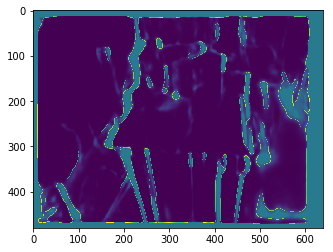

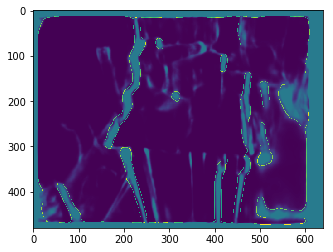

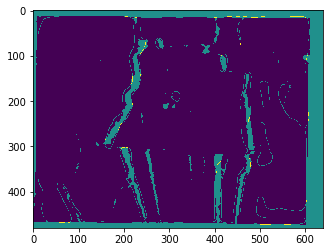

In [279]:
from scipy import ndimage as ndi
from skimage import filter
from skimage import color
from skimage import io
rg = ndi.gaussian_filter(img,4)
edges1 = filter.canny(rg)
edges2 = filter.canny(rg,sigma =6)
plt.figure()
plt.imshow(edges1+img)
plt.figure()
plt.imshow(edges2+img)
plt.figure()
plt.imshow(edges2+img1)

In [293]:
from scipy.ndimage import (gaussian_filter,
                           generate_binary_structure, binary_erosion, label)

In [294]:
%%timeit
gaussian_filter(img, 1, mode='constant')

100 loops, best of 3: 4.56 ms per loop


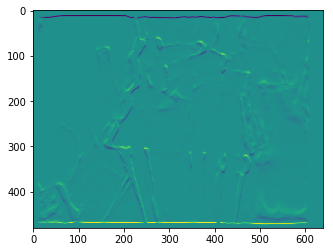

In [299]:
img_smooth = gaussian_filter(img, .5, mode='constant')
plt.imshow(np.gradient(img_smooth)[0])

In [ ]:
"""
canny.py - Canny Edge detector

Reference: Canny, J., A Computational Approach To Edge Detection, IEEE Trans.
    Pattern Analysis and Machine Intelligence, 8:679-714, 1986

Originally part of CellProfiler, code licensed under both GPL and BSD licenses.
Website: http://www.cellprofiler.org
Copyright (c) 2003-2009 Massachusetts Institute of Technology
Copyright (c) 2009-2011 Broad Institute
All rights reserved.
Original author: Lee Kamentsky
"""

import numpy as np
import scipy.ndimage as ndi
from scipy.ndimage import (gaussian_filter,
                           generate_binary_structure, binary_erosion, label)
from .. import dtype_limits
from .._shared.utils import assert_nD


def smooth_with_function_and_mask(image, function, mask):
    """Smooth an image with a linear function, ignoring masked pixels

    Parameters
    ----------
    image : array
        Image you want to smooth.
    function : callable
        A function that does image smoothing.
    mask : array
        Mask with 1's for significant pixels, 0's for masked pixels.

    Notes
    ------
    This function calculates the fractional contribution of masked pixels
    by applying the function to the mask (which gets you the fraction of
    the pixel data that's due to significant points). We then mask the image
    and apply the function. The resulting values will be lower by the
    bleed-over fraction, so you can recalibrate by dividing by the function
    on the mask to recover the effect of smoothing from just the significant
    pixels.
    """
    bleed_over = function(mask.astype(float))
    masked_image = np.zeros(image.shape, image.dtype)
    masked_image[mask] = image[mask]
    smoothed_image = function(masked_image)
    output_image = smoothed_image / (bleed_over + np.finfo(float).eps)
    return output_image


def canny(image, sigma=1., low_threshold=None, high_threshold=None, mask=None,
          use_quantiles=False):
    """Edge filter an image using the Canny algorithm.

    Parameters
    -----------
    image : 2D array
        Greyscale input image to detect edges on; can be of any dtype.
    sigma : float
        Standard deviation of the Gaussian filter.
    low_threshold : float
        Lower bound for hysteresis thresholding (linking edges).
        If None, low_threshold is set to 10% of dtype's max.
    high_threshold : float
        Upper bound for hysteresis thresholding (linking edges).
        If None, high_threshold is set to 20% of dtype's max.
    mask : array, dtype=bool, optional
        Mask to limit the application of Canny to a certain area.
    use_quantiles : bool, optional
        If True then treat low_threshold and high_threshold as quantiles of the
        edge magnitude image, rather than absolute edge magnitude values. If True
        then the thresholds must be in the range [0, 1].

    Returns
    -------
    output : 2D array (image)
        The binary edge map.

    See also
    --------
    skimage.sobel

    Notes
    -----
    The steps of the algorithm are as follows:

    * Smooth the image using a Gaussian with ``sigma`` width.

    * Apply the horizontal and vertical Sobel operators to get the gradients
      within the image. The edge strength is the norm of the gradient.

    * Thin potential edges to 1-pixel wide curves. First, find the normal
      to the edge at each point. This is done by looking at the
      signs and the relative magnitude of the X-Sobel and Y-Sobel
      to sort the points into 4 categories: horizontal, vertical,
      diagonal and antidiagonal. Then look in the normal and reverse
      directions to see if the values in either of those directions are
      greater than the point in question. Use interpolation to get a mix of
      points instead of picking the one that's the closest to the normal.

    * Perform a hysteresis thresholding: first label all points above the
      high threshold as edges. Then recursively label any point above the
      low threshold that is 8-connected to a labeled point as an edge.

    References
    -----------
    .. [1] Canny, J., A Computational Approach To Edge Detection, IEEE Trans.
           Pattern Analysis and Machine Intelligence, 8:679-714, 1986
    .. [2] William Green's Canny tutorial
           http://dasl.mem.drexel.edu/alumni/bGreen/www.pages.drexel.edu/_weg22/can_tut.html

    Examples
    --------
    >>> from skimage import feature
    >>> # Generate noisy image of a square
    >>> im = np.zeros((256, 256))
    >>> im[64:-64, 64:-64] = 1
    >>> im += 0.2 * np.random.rand(*im.shape)
    >>> # First trial with the Canny filter, with the default smoothing
    >>> edges1 = feature.canny(im)
    >>> # Increase the smoothing for better results
    >>> edges2 = feature.canny(im, sigma=3)
    """

    #
    # The steps involved:
    #
    # * Smooth using the Gaussian with sigma above.
    #
    # * Apply the horizontal and vertical Sobel operators to get the gradients
    #   within the image. The edge strength is the sum of the magnitudes
    #   of the gradients in each direction.
    #
    # * Find the normal to the edge at each point using the arctangent of the
    #   ratio of the Y sobel over the X sobel - pragmatically, we can
    #   look at the signs of X and Y and the relative magnitude of X vs Y
    #   to sort the points into 4 categories: horizontal, vertical,
    #   diagonal and antidiagonal.
    #
    # * Look in the normal and reverse directions to see if the values
    #   in either of those directions are greater than the point in question.
    #   Use interpolation to get a mix of points instead of picking the one
    #   that's the closest to the normal.
    #
    # * Label all points above the high threshold as edges.
    # * Recursively label any point above the low threshold that is 8-connected
    #   to a labeled point as an edge.
    #
    # Regarding masks, any point touching a masked point will have a gradient
    # that is "infected" by the masked point, so it's enough to erode the
    # mask by one and then mask the output. We also mask out the border points
    # because who knows what lies beyond the edge of the image?
    #
    assert_nD(image, 2)

    if low_threshold is None:
        low_threshold = 0.1 * dtype_limits(image, clip_negative=False)[1]

    if high_threshold is None:
        high_threshold = 0.2 * dtype_limits(image, clip_negative=False)[1]

    if mask is None:
        mask = np.ones(image.shape, dtype=bool)

    def fsmooth(x):
        return gaussian_filter(x, sigma, mode='constant')

    smoothed = smooth_with_function_and_mask(image, fsmooth, mask)
    jsobel = ndi.sobel(smoothed, axis=1)
    isobel = ndi.sobel(smoothed, axis=0)
    abs_isobel = np.abs(isobel)
    abs_jsobel = np.abs(jsobel)
    magnitude = np.hypot(isobel, jsobel)

    #
    # Make the eroded mask. Setting the border value to zero will wipe
    # out the image edges for us.
    #
    s = generate_binary_structure(2, 2)
    eroded_mask = binary_erosion(mask, s, border_value=0)
    eroded_mask = eroded_mask & (magnitude > 0)
    #
    #--------- Find local maxima --------------
    #
    # Assign each point to have a normal of 0-45 degrees, 45-90 degrees,
    # 90-135 degrees and 135-180 degrees.
    #
    local_maxima = np.zeros(image.shape, bool)
    #----- 0 to 45 degrees ------
    pts_plus = (isobel >= 0) & (jsobel >= 0) & (abs_isobel >= abs_jsobel)
    pts_minus = (isobel <= 0) & (jsobel <= 0) & (abs_isobel >= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    # Get the magnitudes shifted left to make a matrix of the points to the
    # right of pts. Similarly, shift left and down to get the points to the
    # top right of pts.
    c1 = magnitude[1:, :][pts[:-1, :]]
    c2 = magnitude[1:, 1:][pts[:-1, :-1]]
    m = magnitude[pts]
    w = abs_jsobel[pts] / abs_isobel[pts]
    c_plus = c2 * w + c1 * (1 - w) <= m
    c1 = magnitude[:-1, :][pts[1:, :]]
    c2 = magnitude[:-1, :-1][pts[1:, 1:]]
    c_minus = c2 * w + c1 * (1 - w) <= m
    local_maxima[pts] = c_plus & c_minus
    #----- 45 to 90 degrees ------
    # Mix diagonal and vertical
    #
    pts_plus = (isobel >= 0) & (jsobel >= 0) & (abs_isobel <= abs_jsobel)
    pts_minus = (isobel <= 0) & (jsobel <= 0) & (abs_isobel <= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    c1 = magnitude[:, 1:][pts[:, :-1]]
    c2 = magnitude[1:, 1:][pts[:-1, :-1]]
    m = magnitude[pts]
    w = abs_isobel[pts] / abs_jsobel[pts]
    c_plus = c2 * w + c1 * (1 - w) <= m
    c1 = magnitude[:, :-1][pts[:, 1:]]
    c2 = magnitude[:-1, :-1][pts[1:, 1:]]
    c_minus = c2 * w + c1 * (1 - w) <= m
    local_maxima[pts] = c_plus & c_minus
    #----- 90 to 135 degrees ------
    # Mix anti-diagonal and vertical
    #
    pts_plus = (isobel <= 0) & (jsobel >= 0) & (abs_isobel <= abs_jsobel)
    pts_minus = (isobel >= 0) & (jsobel <= 0) & (abs_isobel <= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    c1a = magnitude[:, 1:][pts[:, :-1]]
    c2a = magnitude[:-1, 1:][pts[1:, :-1]]
    m = magnitude[pts]
    w = abs_isobel[pts] / abs_jsobel[pts]
    c_plus = c2a * w + c1a * (1.0 - w) <= m
    c1 = magnitude[:, :-1][pts[:, 1:]]
    c2 = magnitude[1:, :-1][pts[:-1, 1:]]
    c_minus = c2 * w + c1 * (1.0 - w) <= m
    local_maxima[pts] = c_plus & c_minus
    #----- 135 to 180 degrees ------
    # Mix anti-diagonal and anti-horizontal
    #
    pts_plus = (isobel <= 0) & (jsobel >= 0) & (abs_isobel >= abs_jsobel)
    pts_minus = (isobel >= 0) & (jsobel <= 0) & (abs_isobel >= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    c1 = magnitude[:-1, :][pts[1:, :]]
    c2 = magnitude[:-1, 1:][pts[1:, :-1]]
    m = magnitude[pts]
    w = abs_jsobel[pts] / abs_isobel[pts]
    c_plus = c2 * w + c1 * (1 - w) <= m
    c1 = magnitude[1:, :][pts[:-1, :]]
    c2 = magnitude[1:, :-1][pts[:-1, 1:]]
    c_minus = c2 * w + c1 * (1 - w) <= m
    local_maxima[pts] = c_plus & c_minus

    #
    #---- If use_quantiles is set then calculate the thresholds to use
    #
    if use_quantiles:
        if high_threshold > 1.0 or low_threshold > 1.0:
            raise ValueError("Quantile thresholds must not be > 1.0")
        if high_threshold < 0.0 or low_threshold < 0.0:
            raise ValueError("Quantile thresholds must not be < 0.0")

        high_threshold = np.percentile(magnitude, 100.0 * high_threshold)
        low_threshold = np.percentile(magnitude, 100.0 * low_threshold)

    #
    #---- Create two masks at the two thresholds.
    #
    high_mask = local_maxima & (magnitude >= high_threshold)
    low_mask = local_maxima & (magnitude >= low_threshold)
    #
    # Segment the low-mask, then only keep low-segments that have
    # some high_mask component in them
    #
    strel = np.ones((3, 3), bool)
    labels, count = label(low_mask, strel)
    if count == 0:
        return low_mask

    sums = (np.array(ndi.sum(high_mask, labels,
                             np.arange(count, dtype=np.int32) + 1),
                     copy=False, ndmin=1))
    good_label = np.zeros((count + 1,), bool)
    good_label[1:] = sums > 0
    output_mask = good_label[labels]
    return output_mask